# Positioning of a Flexible Head-Disk Drive


This live script considers the problem of positioning a disk read/write head, 
depicted in the figure below (taken from [1]). 

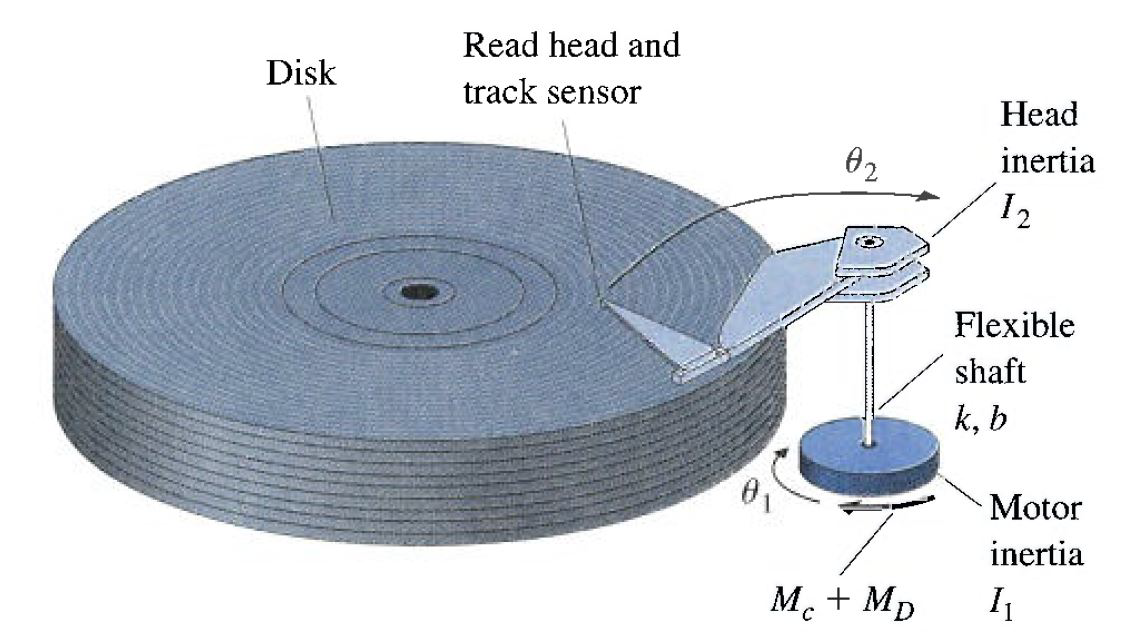


According to [1, Ch.2, Example 2.4] the equations relating the motion of the 
head to the torque applied at the base are

$$I_{1} \ddot{\theta}_{1}(t)+b\left(\dot{\theta}_{1}(t)-\dot{\theta}_{2}(t)\right)+\kappa\left(\theta_{1}(t)-\theta_{2}(t)\right)=M_{c}(t)$$

$$I_{2} \ddot{\theta}_{2}(t)+b\left(\dot{\theta}_{2}(t)-\dot{\theta}_{1}(t)\right)+\kappa\left(\theta_{2}(t)-\theta_{1}(t)\right)=0$$ 

where $\theta_{2}(t)$ is the angle of the head, $\theta_{1}(t)$ is the angle 
of the base, and $M_{c}(t)$ is the torque control input at time $t \in \mathbb{R}_{\geq 
0}$. The parameters in the equations take the following values:

$$M_{c}(t)=u_{k}, \quad t \in[k \tau,(k+1) \tau),$$

where $u_{k}$ is the control input in the interval $[k \tau,(k+1) \tau)$ and 
the full state is assumed to be available at the sampling frequency. We can 
assume that the initial angles and initial angular rates are all zero

$$\theta_{1}(0)=0 \quad \theta_{2}(0)=0 \quad \dot{\theta}_{1}(0)=0 \quad 
\dot{\theta}_{2}(0)=0$$

The goal is to position the head at a desired angle $r$ after $h=100$ time 
steps $(100 \times \tau$ seconds), with an acceptable control input. To this 
effect we consider the problem of minimizing the cost:

$$\left(\sum_{k=0}^{h-1}\left(\theta_{2}(k \tau)-r\right)^{2}+\rho u_{k}^{2}\right)+\alpha\left(\left(\theta_{1}(h 
\tau)-r\right)^{2}+\left(\theta_{2}(h \tau)-r\right)^{2}+0.01 \dot{\theta}_{1}(h 
\tau)^{2}+0.01 \dot{\theta}_{2}(h \tau)^{2}\right)$$

where $\alpha=100$ and $\rho$ is a tuning parameter. 

Note that by defining the state to be 

$$x = [\theta_1-r \ \ \theta_2-r \ \ \dot{\theta}_1 \ \  \dot{\theta}_2]^T$$

we can write

$$\dot{x}= A_cx+B_c u$$

where

$$ A_c = \left[\matrix{0 & 0 & 1 & 0 \cr 0 & 0 & 0 & 1 \cr -\frac{\kappa}{I_1} 
& \frac{\kappa}{I_1} & -\frac{b}{I_1} & \frac{b}{I_1}  \cr\frac{\kappa}{I_2} 
& -\frac{\kappa}{I_2} & \frac{b}{I_2} & -\frac{b}{I_2} }\right], B_c = 
\left[\matrix{0  \cr 0 \cr \frac{1}{I_1} \cr 0}\right]$$

If we denote by $x_k = x(k\tau)$ we can then write posed problem as a standard 
linear quadratic regulator problem

$$\min \sum_{k=0}^{h-1}x_k^TQx_k+u_k^T Ru_k+x_h^TQ_hx_h$$

$$ x_{k+1}=Ax_k+Bu_k$$

where $A$ and $B$ are obtabined from standard zero order hold discretization, 
and 

$ Q= \left[\matrix{0 & 0 & 0 & 0 \cr 0 & 1 & 0 & 0 \cr 0 & 0 & 0 & 0 \cr0 
& 0 & 0 & 0 }\right]$, $ Q_h=\alpha \left[\matrix{1 & 0 & 0 & 0 \cr 0 & 1 & 
0 & 0 \cr 0 & 0 & 0.01 & 0 \cr0 & 0 & 0 & 0.01 }\right]$, $R=\rho$.

The Matlab function `lqrheadiskcontrol` given below computes the optimal control 
inputs $u_{k}$ for $k \in\{0,1, \ldots, h-1\}$by minimizing the mentioned cost. 
The inputs are $\mathrm{r}$ and $\mathrm{rho}=\rho$ and the output is an $h$ 
dimensional row vector with $\mathrm{u}=$ $\left[\begin{array}{lllll}{u_{0}} 
& {u_{1}} & {\ldots u_{h-1}}\end{array}\right]$.


In [ ]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

In [ ]:
def lqrpolicy(A,B,Q,R,Qh,h):
    P = [np.zeros((4,4)) for i in range(h+1)]
    K = [np.zeros((4,1)) for i in range(h)]
    P[h] = Qh
    for k in range(h-1,-1,-1):
        P[k] = A.T @ P[k+1] @ A + Q - A.T @ P[k+1] @ B @ np.linalg.inv(B.T @ P[k+1] @ B + R ) @ B.T @ P[k+1] @ A
        K[k] = -np.linalg.inv(B.T @ P[k+1] @ B + R) @ B.T @ P[k+1] @ A
    
    return K

In [ ]:
def lqrheaddiskcontrol(r,rho):

    #define all the parameters of the problem
    I1    = 2e-5
    I2    = 5e-5
    b     = 2e-3
    kappa = 2e-2
    tau   = 1/1000
    alpha = 100
    h     = 100
    x0    = np.array([-r, -r, 0, 0])
    Ac    = np.array([[ 0, 0, 1, 0],
                    [0, 0, 0, 1],
                    [-kappa/I1, kappa/I1,  -b/I1, b/I1],
                    [kappa/I2, -kappa/I2,   b/I2, -b/I2]])
    Bc    = np.array([[0], [0], [1/I1], [0]])
    Cc = np.eye(Ac.shape[0],Ac.shape[1])
    Dc = np.zeros((4,1))
    A, B = signal.cont2discrete((Ac, Bc, Cc, Dc), tau)[:2]    
    Q     = np.array([[0, 0, 0, 0],
                    [0, 1, 0, 0],
                    [0, 0, 0, 0],
                    [0, 0, 0, 0]])
    R     = rho
    Qh    = alpha*np.array([[1, 0, 0, 0],
                            [0, 1, 0,    0],
                            [0, 0, 0.01, 0],
                            [0, 0, 0,  0.01]])
    n     = A.shape[0]

    # find the gains K{k} of the LQR policy u_k = K{k} xk
    K = lqrpolicy(A,B,Q,R,Qh,h)

    # run the system with the optimal policy
    u  = np.zeros((1,h))
    x  = np.zeros((n,h+1))
    x[0,0] = x0[0]
    x[1,0] = x0[1]
    x[2,0] = x0[2]
    x[3,0] = x0[3]
    for k in range(h):
        u[0][k] = (K[k]@x[:,k])[0]
        aux = A@x[:,k].reshape(4,1)+B*u[0][k]
        x[0,k+1] = aux[0]
        x[1,k+1] = aux[1]
        x[2,k+1] = aux[2]
        x[3,k+1] = aux[3]
    

    # plot system responses
    fig = plt.figure()
    ax = plt.gca()
    ax.plot(np.linspace(0,0.1,101),x[0,:], label="theta1")
    ax.plot(np.linspace(0,0.1,101),x[1,:], label="theta2")
    ax.plot(np.linspace(0,0.1,101),x[2,:], label="dottheta1")
    ax.plot(np.linspace(0,0.1,101),x[3,:], label="dottheta2")
    ax.legend()
    ax.set_xlabel("time")

    
    ax.grid(True)
    fig = plt.figure()
    ax = plt.gca()
    ax.plot(np.linspace(0,0.099,100), u[:][0])
    ax.set_xlabel("time")
    ax.set_ylabel("u")
    ax.grid(True)
    
    
    return u

In [ ]:
# Sample Input Implementation 
r   = -2
rho = 1
u   = lqrheaddiskcontrol(r, rho)

[1] Feedback control of dynamic systems, Franklin, Powell, Emami-Naeini, Pearson, 
7th edition, 2014